## Projeto de Clusterização de Clientes (Setor de Energia Elétrica)

In [2]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Definindo as opções do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_original = pd.read_csv('Dados/consumo_energia.txt', delimiter = ';')

In [4]:
df_original.shape

(2075259, 9)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
df_original.isnull().values.any()

True

In [7]:
df_original.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [8]:
display(df_original.duplicated().sum())

0

In [9]:
# Removendo os valores NA e as colunas desnecessárias (cols 1 e 2)
df_original = df_original.iloc[0:, 2:9].dropna()

In [10]:
df_original.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


O Dataset é um pouco grande, para não precisarmos reparti-lo, vamos tentar trabalhar com um formato mais leve. (CSV -> Parquet)

In [11]:
#!pip install pyarrow
#!pip install fastparquet

In [12]:
# Convertendo as colunas para os tipos de dados adequados
df_original['Voltage'] = df_original['Voltage'].astype(dtype = 'float64')
df_original['Global_active_power'] = df_original['Global_active_power'].astype(dtype = 'float64')
df_original['Global_reactive_power'] = df_original['Global_reactive_power'].astype(dtype = 'float64')
df_original['Global_intensity'] = df_original['Global_intensity'].astype(dtype = 'float64')
df_original['Sub_metering_1'] = df_original['Sub_metering_1'].astype(dtype = 'float64')
df_original['Sub_metering_2'] = df_original['Sub_metering_2'].astype(dtype = 'float64')
df_original['Sub_metering_3'] = df_original['Sub_metering_3'].astype(dtype = 'float64')

# Salvando o DataFrame em formato Parquet
df_original.to_parquet('Dados/consumo_energia.parquet', index=False)

# Carregando o DataFrame a partir do arquivo Parquet
df = pd.read_parquet('Dados/consumo_energia.parquet')

# Verificando se os dados foram carregados corretamente
display(df.head())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 109.4 MB


In [14]:
df.isnull().values.any()

False

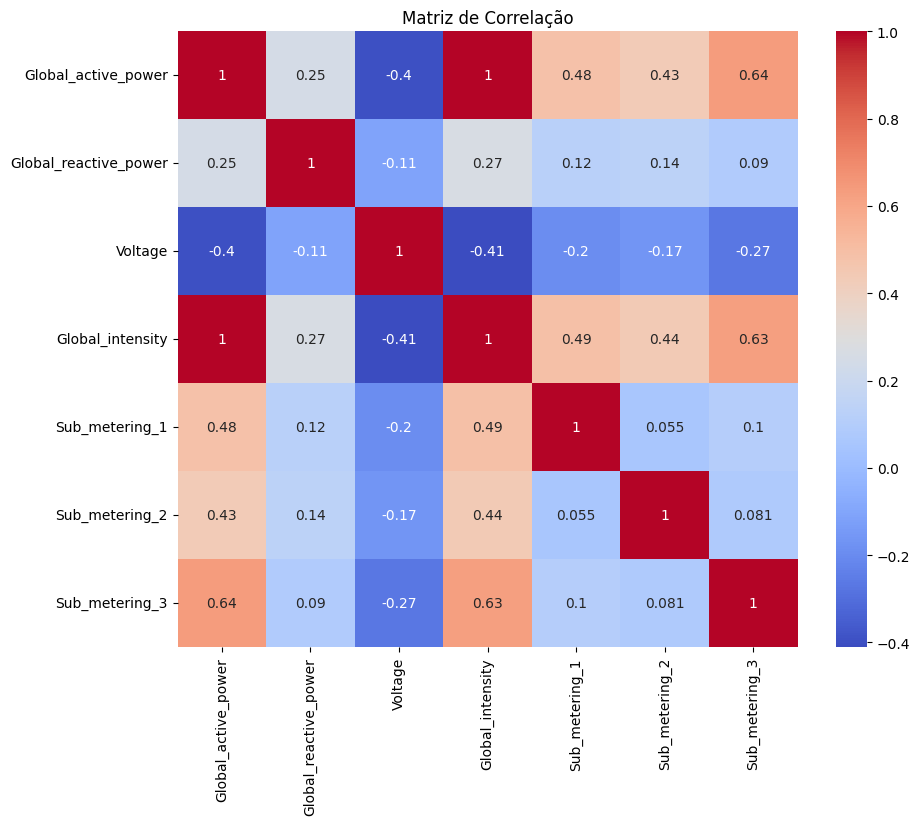

In [15]:
# Identificar correlações entre as variáveis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Clusterização

In [16]:
# Obténdo os valores dos atributos.
df_val = df.values

In [17]:
df_val

array([[  4.216,   0.418, 234.84 , ...,   0.   ,   1.   ,  17.   ],
       [  5.36 ,   0.436, 233.63 , ...,   0.   ,   1.   ,  16.   ],
       [  5.374,   0.498, 233.29 , ...,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.938,   0.   , 239.82 , ...,   0.   ,   0.   ,   0.   ],
       [  0.934,   0.   , 239.7  , ...,   0.   ,   0.   ,   0.   ],
       [  0.932,   0.   , 239.55 , ...,   0.   ,   0.   ,   0.   ]])

In [19]:
# Coletando uma amostra de 2% dos dados para aplicar o K-Means sem pesar muito
amostra1, amostra2 = train_test_split(df_val, train_size = .02)

In [20]:
amostra1.shape

(40985, 7)

In [21]:
# Aplicando redução de dimensionalidade de 7 var para 2 var utilizando Algebra Linear
pca = PCA(n_components = 2).fit_transform(amostra1)

# Determinando um range de K
k_range = range(1,12)

# Criando uma lista com os modelos K-Means treinados para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

# Criando uma lista com os centros cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Criando uma lista contendo a soma dos quadrados das distâncias intra-cluster 
# para cada modelo KMeans treinado.
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados. Valores menores indicam que os pontos dentro de 
# cada cluster estão mais próximos entre si
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters. 
# Entendendo dispersão dos clusters em relação à dispersão total dos dados.
# Valores menores indicam que os pontos dentro de cada cluster são mais distantes.
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

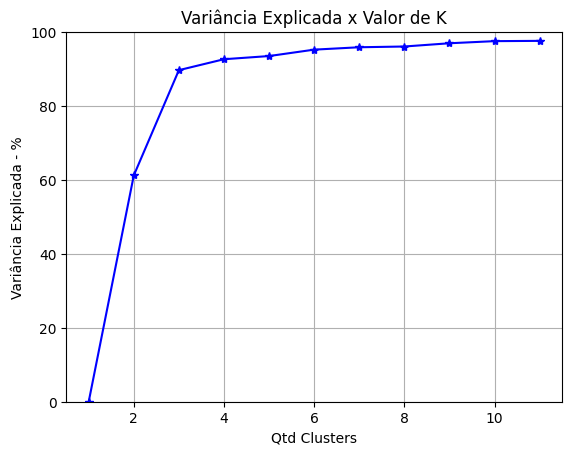

In [22]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Qtd Clusters')
plt.ylabel('Variância Explicada - %')
plt.title('Variância Explicada x Valor de K')

In [23]:
# Criando um modelo com K = 7
modelo_v1 = KMeans(n_clusters = 7)
modelo_v1.fit(pca)

KMeans(n_clusters=7)

In [24]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

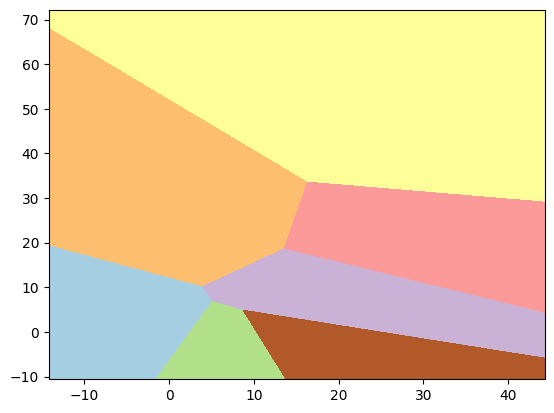

In [25]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

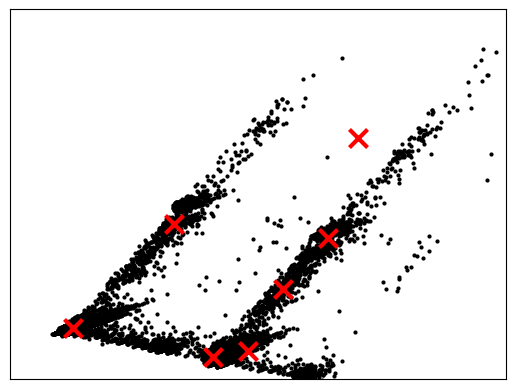

In [26]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [27]:
# Utilizando Silhouette Score para calcular o escore de silhueta para avaliar
# a qualidade dos clusters produzidos pelo modelo KMeans treinado.
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.7666588590152691

Resultado obtido com o modelo_v1 com **K=7**: 0.76665

---

In [28]:
# Criando um modelo com K = 9
modelo_v2 = KMeans(n_clusters = 9)
modelo_v2.fit(pca)

KMeans(n_clusters=9)

In [29]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

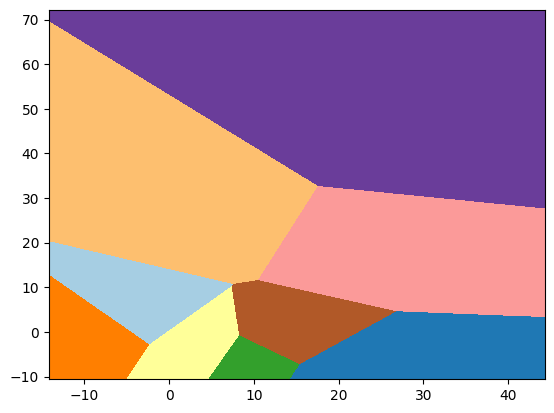

In [30]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

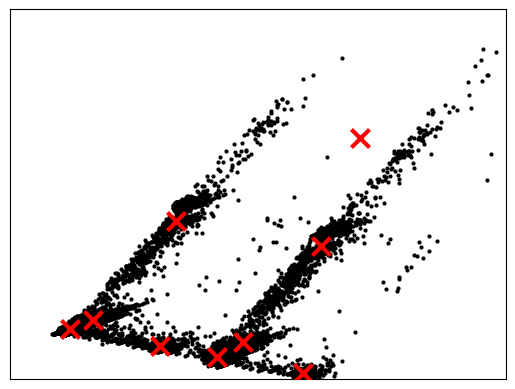

In [31]:
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [32]:
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6431241289449952

Resultado obtido com o modelo_v2 com **K=9**: 0.64312

---

In [33]:
modelo_v3 = KMeans(n_clusters = 6)
modelo_v3.fit(pca)

KMeans(n_clusters=6)

In [34]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

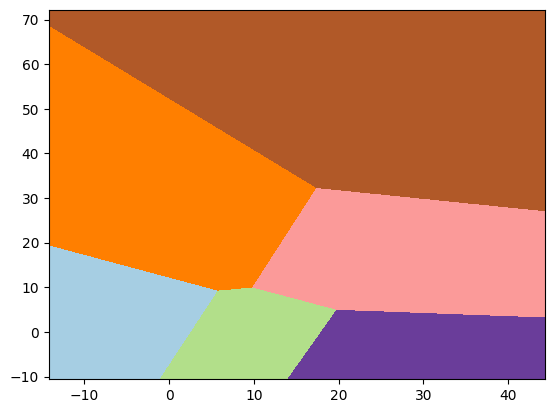

In [35]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

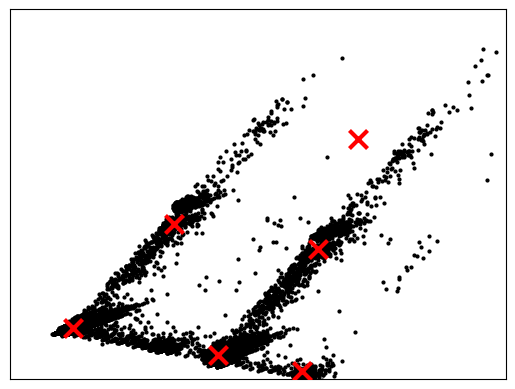

In [36]:
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v3.cluster_centers_
inert = modelo_v3.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [37]:
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8373392689532252

Resultado obtido com o modelo_v3 com **K=6**: 0.83733

---

In [38]:
modelo_v4 = KMeans(n_clusters = 5)
modelo_v4.fit(pca)

KMeans(n_clusters=5)

In [39]:
labels = modelo_v4.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8638501831546802

Resultado obtido com o modelo_v4 com **K=5**: 0.86385

---

In [40]:
modelo_v5 = KMeans(n_clusters = 4)
modelo_v5.fit(pca)

KMeans(n_clusters=4)

In [41]:
labels = modelo_v5.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8267495515035062

Resultado obtido com o modelo_v5 com **K=4**: 82674

---

### **Resumo dos modelos (Escore de silhueta):**

No modelo_v1 com k=7: 0.7666588590152691  
No modelo_v2 com k=9: 0.6431241289449952  
No modelo_v3 com k=6: 0.8373392689532252  
No modelo_v4 com k=5: 0.8638501831546802  
No modelo_v5 com k=4: 0.8267495515035062  

Dentre os modelos testados, o que obteve o maior escore de silhueta foi o **modelo_v4**, que com **k=5** (5 cluters) conseguiu um escore de **0.8638501831546802**, que é mais alto do que os outros modelos testados. Isso sugere que esse modelo com esse número de clusters pode ser mais apropriado para esses dados.

---

### Análise visual dos clusters: 

Analisando o modelo_v4 com k=5 (5 clusters) que obteve o melhor escore de silhueta.

In [42]:
# Definindo os nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [44]:
# Criando um DataFrame com os dados da amostra (cluster map)
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v4.labels_

In [45]:
cluster_map.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.080,0.000,240.08,0.2,0.0,0.0,1.0,0
1,0.212,0.000,241.77,1.0,0.0,0.0,1.0,0
2,2.952,0.384,240.46,12.4,0.0,1.0,18.0,1
3,2.164,0.196,240.42,9.0,0.0,0.0,19.0,1
4,0.342,0.208,240.56,1.6,0.0,2.0,1.0,0
5,2.502,0.082,235.65,10.8,0.0,27.0,0.0,2
6,1.570,0.056,237.83,6.6,0.0,0.0,18.0,1
7,2.092,0.050,241.90,8.6,0.0,0.0,19.0,1
8,0.360,0.222,242.34,1.8,0.0,0.0,1.0,0
9,0.294,0.000,247.51,1.2,0.0,0.0,0.0,0


In [46]:
cluster_map.tail(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
40975,1.424,0.120,239.42,5.8,1.0,0.0,18.0,1
40976,1.040,0.164,237.14,4.4,0.0,0.0,0.0,0
40977,1.480,0.216,237.43,6.2,0.0,2.0,18.0,1
40978,0.232,0.126,240.79,1.0,0.0,1.0,0.0,0
40979,1.686,0.086,238.35,7.0,0.0,0.0,18.0,1
40980,4.342,0.194,239.43,18.0,38.0,1.0,0.0,2
40981,0.434,0.000,239.33,1.8,0.0,0.0,1.0,0
40982,0.718,0.208,239.84,3.0,0.0,4.0,0.0,0
40983,2.654,0.288,239.40,11.0,0.0,38.0,1.0,2
40984,5.142,0.278,237.98,21.6,52.0,0.0,1.0,4


In [47]:
# Calculando o agrupamento
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.518148
1    1.798566
2    2.940651
3    4.097858
4    5.789400
Name: Global_active_power, dtype: float64

In [48]:
# Qtd de observações por cluster
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0    25769
1    13056
2      784
3     1166
4      210
Name: Global_active_power, dtype: int64

Ao observar o desempenho do modelo que obteve o melhor resultado no escore de silhueta, podemos perceber que a clusterização tendeu a se concentrar em dois clusters principais, o que indica que apesar do resultado matemático apontar o modelo como o melhor modelo, talvez seja prudente gerarmos um cluster map para modelos com um maior número de clusters ou aplicar técnicas de normalização nos dados que serão usados no modelo.

Analisando o modelo_v1 com k=7 (7 clusters) que obteve o segundo pior escore de silhueta.

In [49]:
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [50]:
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.517921
1    1.546873
2    4.307379
3    2.942880
4    3.295994
5    5.805902
6    2.841403
Name: Global_active_power, dtype: float64

In [51]:
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0    25756
1    10531
2      892
3      782
4      359
5      204
6     2461
Name: Global_active_power, dtype: int64

Ao analisar o modelo com um número maior de clusters, pode-se observar que realmente existe uma tendência da concentração de determinadas características que em elementos que estão agrupados em 2 grandes grupos.  
Vamos tentar aplicar o modelo_v4 com 5 clusters nos mesmos dados, só que agora normalizados.

Modelo_v6 reproduzindo o modelo_v4 com k=5 (5 clusters) com dados normalizados.

In [56]:
# Extraindo os valores do DataFrame
df_val = df.values

# Padronizando os valores utilizando MinMaxScaler
Padronizador = MinMaxScaler()
df_val = Padronizador.fit_transform(df_val)

# Dividindo os dados em conjunto de treinamento e teste
amostra3, amostra4 = train_test_split(df_val, train_size=.02)

# Realizando a redução de dimensionalidade usando PCA
pca = PCA(n_components=2).fit_transform(amostra3)

# Definindo uma faixa de valores para o número de clusters
k_range = range(1, 12)

# Treinando modelos KMeans com diferentes números de clusters
k_means_var = [KMeans(n_clusters=k).fit(pca) for k in k_range]

# Obtendo os centróides de cada cluster
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando as distâncias dos pontos aos centróides
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]

# Calculando as menores distâncias de cada ponto ao seu centróide
dist = [np.min(ke, axis=1) for ke in k_euclid]

# Calculando a soma dos quadrados das distâncias intra-cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Calculando a soma total dos quadrados das distâncias
soma_total = sum(pdist(pca)**2) / pca.shape[0]

# Calculando a soma dos quadrados das distâncias inter-cluster
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Treinando o modelo KMeans final com o número ideal de clusters
modelo_v6 = KMeans(n_clusters=5)
modelo_v6.fit(pca)

# Definindo a grade para a visualização da superfície de decisão
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# Prevêndo os clusters para cada ponto na grade
Z = modelo_v6.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Obténdo os rótulos de cluster do modelo
labels = modelo_v6.labels_

# Calculando o escore de silhueta para avaliar a qualidade dos clusters
silhouette_score(pca, labels, metric='euclidean')

# Definindo os nomes das colunas do DataFrame original
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Criando um DataFrame para mapear os pontos originais aos clusters
cluster_map = pd.DataFrame(amostra3, columns=names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v6.labels_

In [57]:
cluster_map.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.016114,0.097842,0.610662,0.020747,0.0,0.0000,0.000000,0
1,0.178345,0.074820,0.606462,0.170124,0.0,0.0000,0.387097,3
2,0.184501,0.043165,0.636834,0.174274,0.0,0.0000,0.580645,3
3,0.013942,0.168345,0.578352,0.020747,0.0,0.0000,0.000000,0
4,0.029151,0.082014,0.719871,0.029046,0.0,0.0000,0.000000,0
5,0.019736,0.172662,0.563489,0.029046,0.0,0.0125,0.000000,4
6,0.034764,0.000000,0.601939,0.037344,0.0,0.0000,0.000000,0
7,0.109180,0.041727,0.565751,0.103734,0.0,0.0000,0.548387,3
8,0.139779,0.215827,0.478837,0.136929,0.0,0.0125,0.580645,3
9,0.020822,0.063309,0.580291,0.020747,0.0,0.0250,0.000000,0


In [58]:
cluster_map.tail(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
40975,0.182328,0.057554,0.571890,0.174274,0.011364,0.0000,0.612903,3
40976,0.024081,0.000000,0.694992,0.024896,0.011364,0.0000,0.000000,0
40977,0.151367,0.048921,0.486268,0.149378,0.000000,0.0000,0.000000,4
40978,0.047438,0.207194,0.573506,0.053942,0.000000,0.0000,0.000000,4
40979,0.130183,0.119424,0.864620,0.120332,0.000000,0.0000,0.612903,3
40980,0.022089,0.046043,0.671082,0.024896,0.000000,0.0000,0.000000,0
40981,0.025892,0.093525,0.818094,0.029046,0.000000,0.0125,0.032258,0
40982,0.026073,0.057554,0.577060,0.029046,0.000000,0.0000,0.000000,0
40983,0.039109,0.066187,0.694346,0.037344,0.000000,0.0250,0.000000,0
40984,0.027159,0.043165,0.491438,0.029046,0.000000,0.0000,0.032258,4


### Resultado da clusterização

In [59]:
# Verificando o número de clusters
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0    17883
1     1830
2     1105
3    12229
4     7938
Name: Global_active_power, dtype: int64